# This notebook contains SARIMA model for prometheus metrics "disk_writes:rate" forcasting and anomaly detections.

SARIMA stands for "Seasonal Auto Regression Integrated Moving Average"

# SARIMA Model
Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series. 
There are three trend elements that require configuration. 
These are the ones that are configured in the standard ARIMA model.

p - Trend autoregression order
d - Trend difference order
q - Trend moving average order
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.


In [8]:
# import all required library
import pandas as pd
from datetime import datetime
import numpy as np

from statsmodels.tsa.stattools import adfuller

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


# Data Pre-processing (Load sample metric data set as Json and fetch metric timestamp and corresponding metric value from the data set)


def process_data(data, freq):
    values_col = data["values"]
    #print(values_col.head())
    new = []
    for x in values_col:
         for y in x:
             y[0] = datetime.fromtimestamp(y[0])
             y[1] = float(y[1])

         new = new + x

    values_col = pd.DataFrame(new)
    print("Orignal data sets having : rows = {0} and columns = {1}".format(len(values_col),len(values_col.columns)))
    #values_col.info()
    #print(values_col.head())
    
    Sample_data = values_col.iloc[:25000]
    print("Total row's and column available in sample data sets are : rows = {0} and columns = {1}".format(len(Sample_data),len(Sample_data.columns)))
    #Sample_data.info()
    print(Sample_data.head())
    # Now rename column zero as date
    Sample_data.rename(columns = {0: 'Date'}, inplace = True)
    # add column name 'datetime' with data from 'Date' column in dataframe.
    # Convert the dataframe into timeseries format
    Sample_data['datetime'] = pd.to_datetime(Sample_data['Date'])
    Sample_data= Sample_data.set_index('datetime')
    Sample_data.drop(['Date'], axis = 1, inplace = True)
    Sample_data.rename(columns = {1: 'value'}, inplace = True)
    # Compress the timeseries into (1h/ 0.5h/ 0.25/) frequency
    # aggregating second/minute data reading in to hourly points
    Sample_data = Sample_data.resample(freq).mean()
    #print(Sample_data.head())
    Sample_data.index.freq = 'H'
    return Sample_data
    
def split_data(dataframe):
    #Dividing the data set into (80%)training and (20%)testing samples
    dataframe = dataframe.sort_values(by ='datetime')
    ratio = 0.2
    size = int(len(dataframe) * (1-float(ratio)))
    #train, test = dataframe[0:size], dataframe[size:len(dataframe)]
    train, test = dataframe[:size], dataframe[size:]
    return train, test
    
    





In [2]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [9]:
def _sarima(train, test, freq):
    sfrequency = 0
    if freq == '1h':
        sfrequency = 24
    elif freq == '30Min':
        sfrequency = 48
    elif freq == '15Min':
        sfrequency = 96
        
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0,0,2,sfrequency), enforce_stationarity = True, enforce_invertibility = False)
    #model_fit = model.fit(dsip=-1)
    model_fit = model.fit(dsip=-1)
    residuals = pd.DataFrame(model_fit.resid)
    
    residuals.plot()
    print("Now plotting the residual errors for the SARIMA model")
    plt.show()
    
    residuals.plot(kind='kde')
    print("Now plotting the desity of the residual error values.")
    plt.show()
    
    print(residuals.describe())
    
    # Obtain predicted values
    start=len(train)
    end=len(train)+len(test)-1
    forecast = model_fit.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,2,2)(2,2,2,24) Predictions')
    
    
    #K = len(test)

    #forecast = model_fit.forecast(K)
    # forecast = np.exp(forecast)
    forecast = pd.DataFrame(forecast.values, columns = ['predict'], index = test.index)

    plt.plot(forecast, label='forecast')
    plt.show()
    plt.figure(figsize=(12,5), dpi=100)
    # plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(forecast, label='forecast')
    # plt.title('RMSE: %.2f'% np.sqrt(sum((forecast-test)**2)/len(test)))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    return model, model_fit, forecast

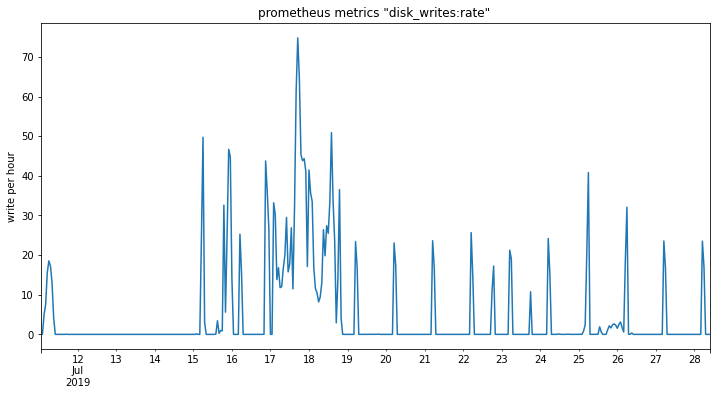

In [12]:
# plot the source data
title = 'prometheus metrics "disk_writes:rate" '
ylabel='write per hour'
xlabel='' # we don't really need a label here

ax = processed_data['value'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

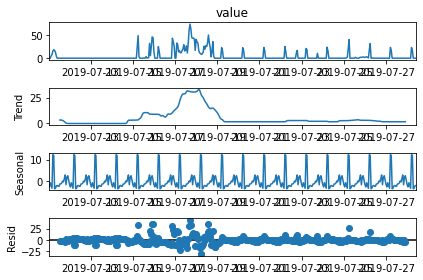

In [13]:
#Run an ETS Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
result = seasonal_decompose(processed_data['value'], model='add')
result.plot();

In [ ]:
# now lets check data is stationary or not using dickey fuller test
adf_test(processed_data)

In [ ]:
# For SARIMA Orders we set seasonal=True and pass in an m value
#from pmdarima import auto_arima  # for determining ARIMA orders
#auto_arima(processed_data['value'],start_p=0,start_P=0,start_q=0,start_Q=0,max_P=2,max_q=2,max_Q=2,max_D=2,seasonal=True,m=24).summary()
#auto_arima(processed_data['value'],seasonal=True,m=24).summary()

In [ ]:
len(processed_data)

Orignal data sets having : rows = 1162918 and columns = 2
Total row's and column available in sample data sets are : rows = 25000 and columns = 2
                        0    1
0 2019-07-11 01:28:00.825  0.0
1 2019-07-11 01:29:00.825  0.0
2 2019-07-11 01:30:00.825  0.0
3 2019-07-11 01:31:00.825  1.7
4 2019-07-11 01:32:00.825  0.0
418
334
84
Now plotting the residual errors for the SARIMA model


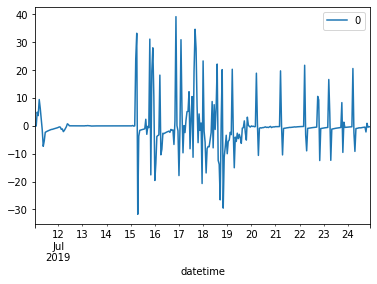

Now plotting the desity of the residual error values.


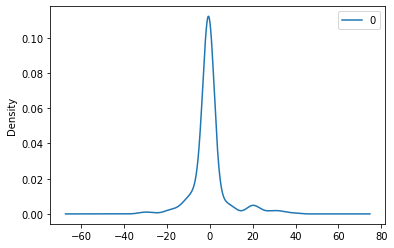

                0
count  334.000000
mean    -0.027281
std      8.045486
min    -31.739590
25%     -1.446102
50%     -0.464284
75%     -0.001657
max     39.193627


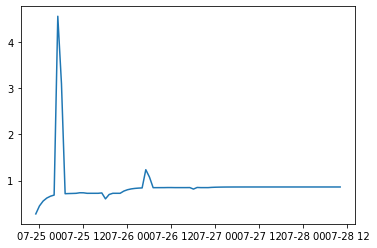

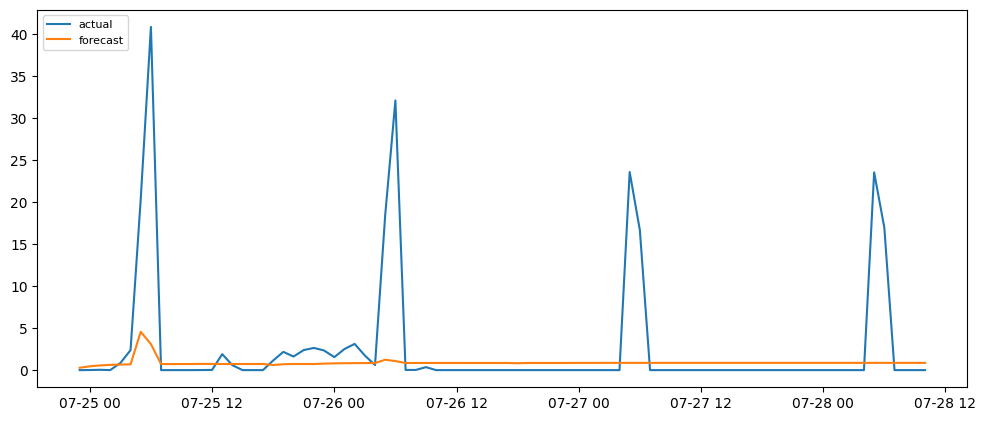

In [11]:
data = pd.read_json("201910081557.json")
processed_data = process_data(data,'1h')
#print(type(processed_data))

train, test = split_data(processed_data)
print(processed_data.size)
print(train.size)
print(test.size)

model, model_fit, forecast = _sarima(train, test, '1h')
#print(forecast.len())

In [14]:
# Compare predictions to expected values and evaluate error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error

RMSE = rmse(test, forecast)
#print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')
print("value of rmse is {}".format(RMSE))
MSE = mean_squared_error(test, forecast)
print("value of mse is {}".format(MSE))
print("value of test data mean is {}".format(test.mean()))

value of rmse is [7.34569161]
value of mse is 53.95918526310133
value of test data mean is value    2.623333
dtype: float64


In [15]:
# Compare predictions to expected values
for i in range(len(forecast)):
    print(f"predicted={forecast['predict'][i]:<11.10}, expected={test['value'][i]}")

predicted=0.280925051, expected=0.0
predicted=0.4533705721, expected=0.01
predicted=0.5590043719, expected=0.04
predicted=0.6238113446, expected=0.0
predicted=0.6635587331, expected=0.8416666666666667
predicted=0.6879943883, expected=2.3787499999999997
predicted=4.553197945, expected=20.360829937584892
predicted=3.0975023  , expected=40.820357116072095
predicted=0.7177388712, expected=0.0
predicted=0.7211906192, expected=0.0
predicted=0.7233178159, expected=0.0
predicted=0.72615654 , expected=0.0
predicted=0.7380863288, expected=0.009166666666666667
predicted=0.7371286543, expected=0.02041666666666667
predicted=0.7262034411, expected=1.902499750064583
predicted=0.7264055245, expected=0.58125
predicted=0.7264824933, expected=0.0
predicted=0.7265540573, expected=0.0
predicted=0.7343202684, expected=0.0
predicted=0.6059854755, expected=1.1449988021132806
predicted=0.7007094012, expected=2.1695824791880205
predicted=0.7266272746, expected=1.6170833333333334
predicted=0.7266348269, expected

                      predict
datetime                     
2019-07-24 23:00:00  0.280925
2019-07-25 00:00:00  0.453371
2019-07-25 01:00:00  0.559004
2019-07-25 02:00:00  0.623811
2019-07-25 03:00:00  0.663559
[[       nan]
 [       nan]
 [0.28092505]
 [0.29456826]
 [0.31445445]]
[[       nan]
 [       nan]
 [0.62581609]
 [0.75301795]
 [0.83315   ]]
                        value   predict
datetime                               
2019-07-24 23:00:00  0.000000  0.280925
2019-07-25 00:00:00  0.010000  0.453371
2019-07-25 01:00:00  0.040000  0.559004
2019-07-25 02:00:00  0.000000  0.623811
2019-07-25 03:00:00  0.841667  0.663559
                        value   predict
datetime                               
2019-07-24 23:00:00  0.000000  0.280925
2019-07-25 00:00:00  0.010000  0.453371
2019-07-25 01:00:00  0.040000  0.559004
2019-07-25 02:00:00  0.000000  0.623811
2019-07-25 03:00:00  0.841667  0.663559
                            0
datetime                     
2019-07-24 23:00:00       Na

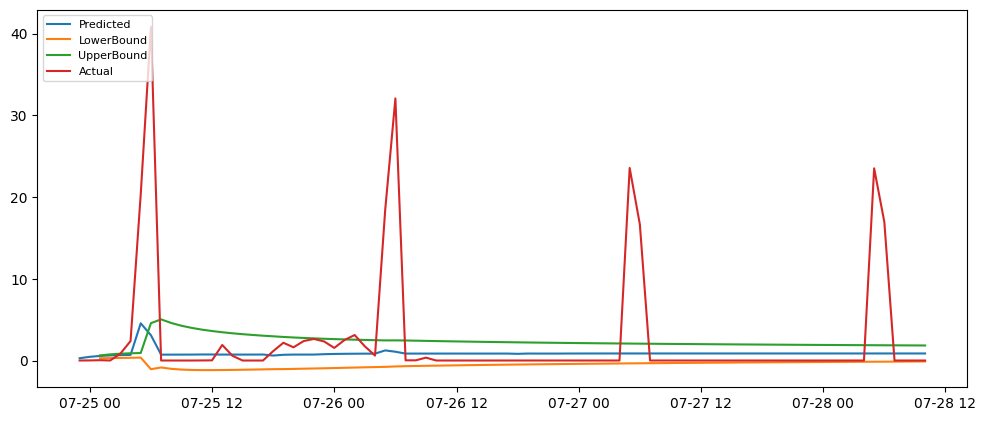

In [16]:
def evaluation(forecast, test):
    upper_bound = np.array(
      [
        (
         float(np.ma.average(forecast[:i], axis = 0,weights=np.linspace(0, 1, num=len(forecast[:i]))))
          + (np.std(forecast[:i]) * 2)
        )
        for i in range(len(forecast))
        ]
    )
      # to account for no std of a single value
      # np.ma.average --> Return the weighted average of array over the given axis.  
      # https://numpy.org/doc/stable/reference/generated/numpy.ma.average.html
      # np.linspace-->  Return evenly spaced numbers over a specified interval.
      # https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
        
    lower_bound = np.array(
      [
        (
          float(np.ma.average(
            forecast[:i],axis = 0,
            weights=np.linspace(0, 1, num=len(forecast[:i])),))
          - (np.std(forecast[:i]) * 2)
        )
        for i in range(len(forecast))
        ]
    )
    
    
    return upper_bound, lower_bound
    

upper_bound, lower_bound = evaluation(forecast, test)
print(forecast.head())
print(lower_bound[0:5])
print(upper_bound[0:5])

compare = test.join(forecast, how = 'outer')
#https://www.datacamp.com/community/tutorials/joining-dataframes-pandas

print(compare.head())
compare = compare.dropna()
print(compare.head())
lower = pd.DataFrame(lower_bound, columns = [0], index = test.index)
upper = pd.DataFrame(upper_bound, columns = [0], index = test.index)
print(lower.head())
print(upper.head())

compare.insert(2, "LowerBound", lower, True)
compare.insert(3, "UpperBound", upper, True)
print(compare.head(20))
compare['WithinUpperBounds'] = compare['predict'] < compare['UpperBound']
compare['WithinLowerBounds'] = compare['predict'] > compare['LowerBound']
    
#Detecting anomalies
anomaly = []
for i in range(len(compare)):
    if((compare['value'][i] < compare['UpperBound'][i]) and (compare['value'][i] > compare['LowerBound'][i])):
        anomaly.append(0)
    else:
        anomaly.append(1)
    
compare.insert(6, "Anomaly", anomaly, True)
print("The final dataframe with lowerbound, upperbound and prediction value:\n")
print(compare.head(20))

plt.figure(figsize=(12,5), dpi=100)
plt.plot(compare['predict'], label='Predicted')
plt.plot(compare['LowerBound'], label='LowerBound')
plt.plot(compare['UpperBound'], label='UpperBound')
plt.plot(compare['value'], label='Actual')
# plt.title('RMSE: %.2f'% np.sqrt(sum((forecast-test)**2)/len(test)))
plt.legend(loc='upper left', fontsize=8)
plt.show()